# P6. Changing the underlying grid of data through regridding
## Practical Notebook 6 (of 6) for *Intro to the NCAS CF Data Tools, cf-python and cf-plot*

**In this section we demonstrate how to change the underlying grid of the data to another grid which could be a higher- or lower- resolution one, or a completely different grid, which is called regridding or interpolation, and indicate various options cf-python supports for doing this.**

***

<div class="alert alert-block alert-success">
<i>Practical instructions:</i> run the cell in this section to do the set up, which is not part of the practical proper.
</div>

## Setting up

**In this short prelude we set up this Notebook, import the libraries and check the data we will work with, ready to use the libraries and the data (exactly as per the first Notebook setup but in one cell only for quick execution).**

In [1]:
# Set up for inline plots - only needed inside a Notebook environment - and to ignore some repeating warnings
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Import the two CF Data Tools libraries and inspect the versions
import cfplot as cfp
import cf
print("--- Version report: ---")
print("cf-python version is:", cf.__version__)
print("cf-plot version is:", cfp.__version__)
print("CF Conventions version is:", cf.CF())

# See what datasets we have to explore within the data directory we use throughout this course
print("--- Datasets available from the path '../data': ---")
# Note that in a Jupyter Notebook, '!' precedes a shell command - so this is a command, not Python
!ls ../data

--- Version report: ---
cf-python version is: 3.18.1
cf-plot version is: 3.4.0
CF Conventions version is: 1.12
--- Datasets available from the path '../data': ---
160by320griddata.nc			   precip_2010.nc
aaaaoa.pmh8dec.pp			   precip_DJF_means.nc
alpine_precip_DJF_means.nc		   qbo.nc
data1.nc				   regions.nc
data1-updated.nc			   rgp.nc
data2.nc				   sea_currents_backup.nc
data3.nc				   sea_currents.nc
data5.nc				   ta.nc
ggas2014121200_00-18.nc			   tripolar.nc
IPSL-CM5A-LR_r1i1p1_tas_n96_rcp45_mnth.nc  two_fields.nc
land.nc					   ua.nc
model_precip_DJF_means_low_res.nc	   u_n216.nc
model_precip_DJF_means.nc		   u_n96.nc
n2o_emissions.nc			   vaAMIPlcd_DJF.nc
POLCOMS_WAM_ZUV_01_16012006.nc		   va.nc
precip_1D_monthly.nc			   wapAMIPlcd_DJF.nc
precip_1D_yearly.nc


***

<div class="alert alert-block alert-success">
<i>Practical instructions:</i> now we can start the practical. We will follow the same sectioning as in the teaching notebook, so please consult the notes there in the matching section for guidance and you can also consult the cf-python and cf-plot documentation linked above.
</div>

## 6. Changing the underlying grid of data through regridding

### a) Getting a _source_ field ready to regrid

**6.a.1)** Define a new variable 'yearly_field' set to the first field in the FieldList read-in from the netCDF dataset `precip_1D_yearly.nc` which lives in the usual directory, `../data`. Inspect it with medium level of detail.

In [5]:
yearly_field = cf.read("../data/precip_1D_yearly.nc")[0]
print(yearly_field)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(10): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


**6.a.2)** This will be our source field for regridding. Note it is a time series, not a dataset defined across different points in space! We can regrid data on any axis or axes, they do not have to represent spatial coordinates, including 1D series. In this case, we have an effectively 1D (3D but with two of the axes size one, hence of size which can be ignored) time series and we are going to regrid it. For a time series, visually this

Make a line plot of the time series in `yearly_field` to see it. Add the argument `marker="o"` to the call which plots markers against the individual data points forming the line. With the markers on we can see the discrete sample points that make up the data represented by the continuous line.

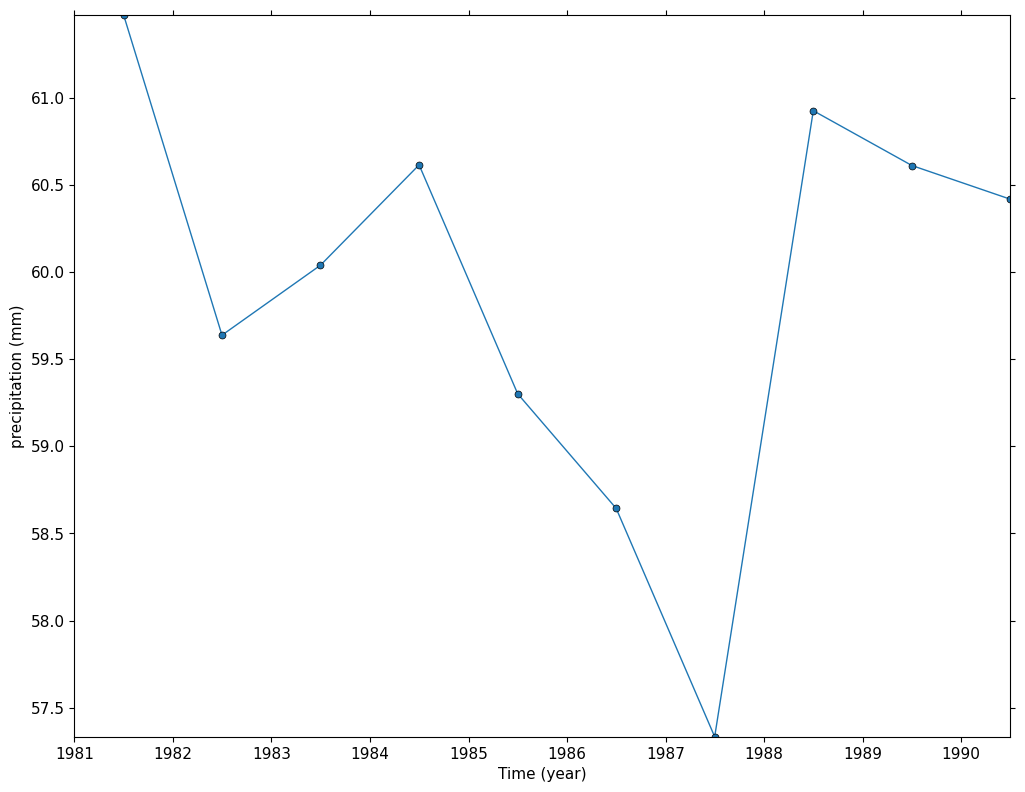

In [6]:
cfp.lineplot(yearly_field, marker="o")

### b) Getting the _destination_ field: another field in order to regrid the previous _onto its grid_

**6.b.1)** Let's get another time series field, but one with a different sampling resolution. The sampling of time points across the axes is the *grid* in this context. For our destination field, we will take a series which is sampled at higher resolution.

Define a new variable 'monthly_field' set to the first field in the FieldList read-in from the netCDF dataset `precip_1D_monthly.nc` which lives in the usual directory, `../data`. Inspect it with medium level of detail.

In [7]:
# Read in another precipitation field, with more time axis points, and inspect it
monthly_field = cf.read("../data/precip_1D_monthly.nc")[0]
print(monthly_field)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


**6.b.2)** As the name of the corresponding read-in files suggests, this `dest_field` represents monthly data and the `source_field` represents yearly data, so `dest_field` is around 12 times the resolution of the `source_field`.

Make a line plot of the `dest_field` showing the markers for the discrete data points. Compare this line plot to the one above with respect to the time axis (on the x-axis) to confirm the difference in sampling frequencies of around x12. Note we don't care about the values of the data at each point and whether it is different to the data of the source grid we are considering! All we want to extract from this destination field time series is the time point sampling, our destination grid. (Likewise, in the teaching Notebook where we did horizontal spatial grid regridding, the data defined on the destination grid `lower_res_field` did not matter, just the grid points it was defined on.)

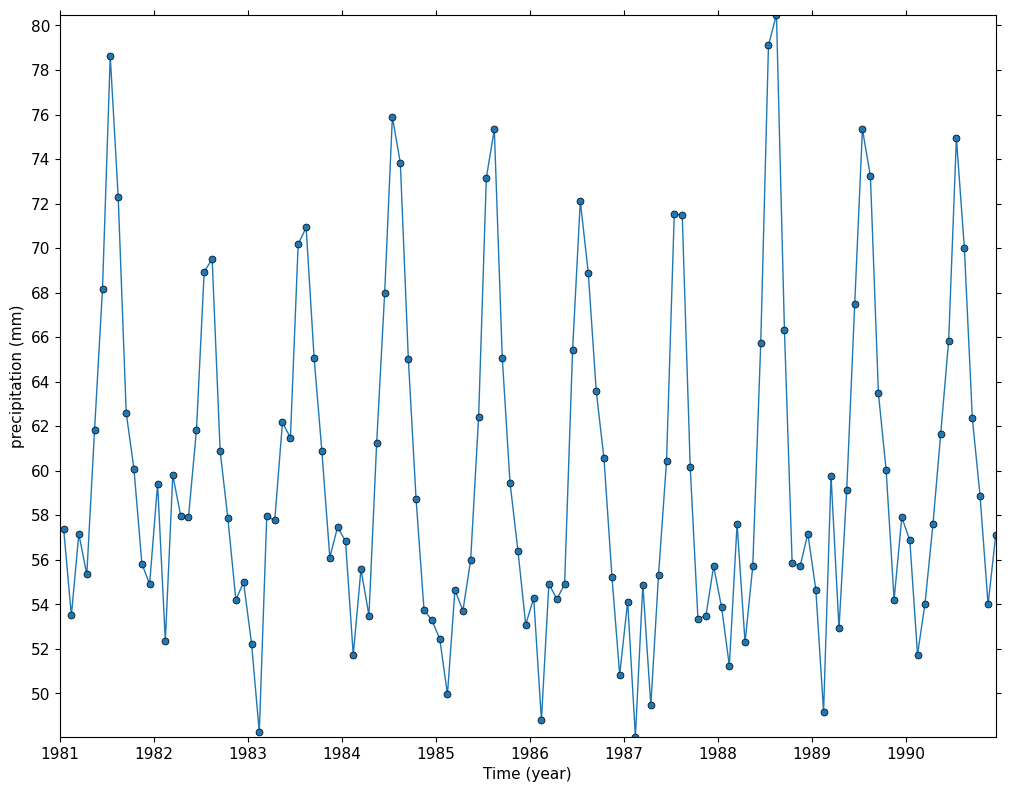

In [8]:
cfp.lineplot(monthly_field, marker="o")

### c) Performing the regrid operation from the source to the destination fields

**6.c.1)** Before we do the regridding operation, let's demonstrate briefly how to remove any size one axes from a field. Note this is not necessary in order to do the regridding, but it can 'tidy up' the fields so they don't have size one axes attached, which can be useful in cases like this because it means the axes are both 1D so it is simpler to interpret the regridding we are doing. To remove the size one axes of a field, apply the `squeeze()` method: you can either re-assign the field with `squeeze()` applied to the same variable name, or use the `inplace=True` argument to the method which changes the field in-place i.e. to the variable storing it without the need to re-assign.

Apply the `squeeze` method to the `monthly_field` and the `yearly_field` and inspect the results of each with medium level of detail.

In [9]:
monthly_field = monthly_field.squeeze()  # or just monthly_field.squeeze(inplace=True)
print(monthly_field)
yearly_field = yearly_field.squeeze()  # or just yearly_field.squeeze(inplace=True)
print(yearly_field)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east
Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10)) mm
Cell methods    : long_name=time(10): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


**6.c.2)** Now to do the actual regridding operation! (You could call all the field methods such as reading, indexing and squeezing in the same line as the actual regrid operation, but doing so would be harder to interpret and to debug in case something wasn't speciied correctly, or some other issue, so we have worked these out step-by-step as better practice.)

In the teaching Notebook we used the `regrids` method which performs *spherical* regridding (`s` for spherical) because longitude and latitude are defined on the Earth's surface which forms a spherical coordinate system (you can read more about spherical regridding if desired here: https://ncas-cms.github.io/cf-python/tutorial.html#spherical-regridding).

But that is not appropriate here because we aren't considering coordinates defined on a spherical surface, so we need to use *Cartesian* regridding. We use the `regridc` method of cf-python to do this, where the `c` in the name stands for the 'C' of Cartesian, which is the appropriate type here and in general you should use when considering any axes in Euclidean (ie. flat/non-curved) space (you can read more about Cartesian regridding if desired here: https://ncas-cms.github.io/cf-python/tutorial.html#cartesian-regridding).

With that in mind, take the source and destinations fields we set up in the previous sub-sections and apply the cf-python Cartesian regridding operation to regrid `yearly_field` to the grid (i.e. the sampling resolution in this 1D case) of `monthly_field`, assigning the output to a new variable `linear_regridded_field`. Use the `"linear"` argument to `method` to use linear interpolation as the regridding method, this time. You will need to set a further argument for Cartesian regridding, namely `axes="T"` to indicate that we want to regrid over the 'time'/'T' axis.

In [10]:
linear_regridded_field = yearly_field.regridc(monthly_field, method="linear", axes="T")
print(linear_regridded_field)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120)) mm
Cell methods    : long_name=time(120): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


**6.c.3)** Make a line plot of `linear_regridded_field`, including the argument `marker="o"` so that we can see the discrete points the line is based upon.

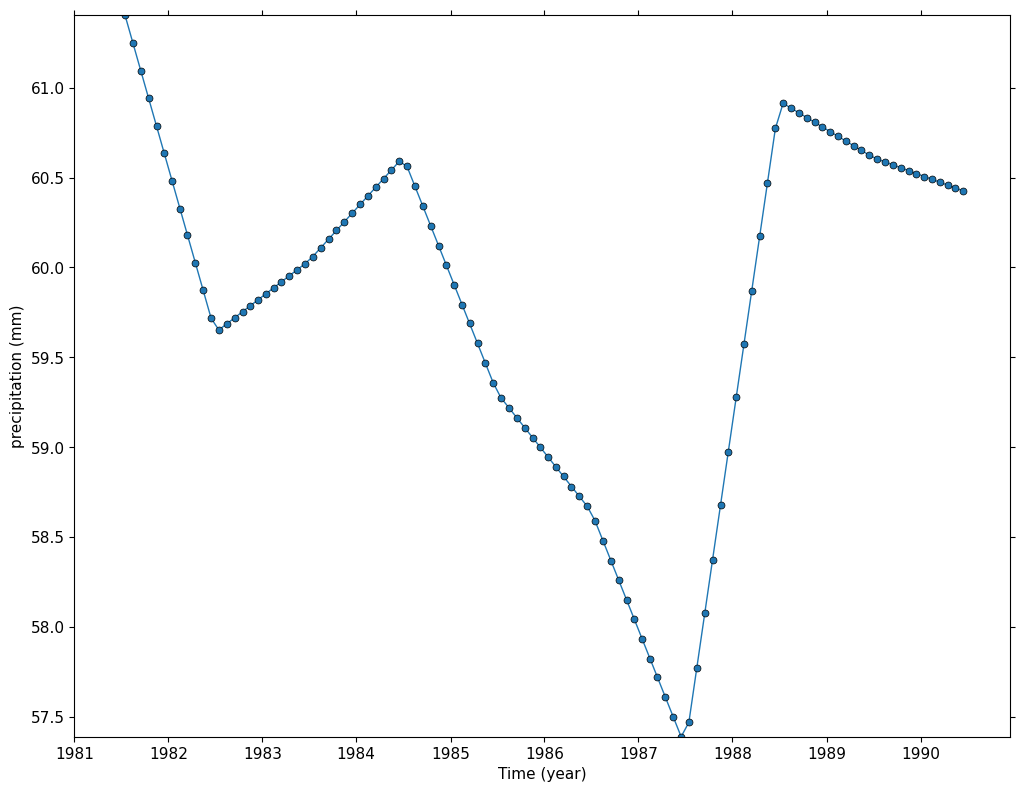

In [11]:
cfp.lineplot(linear_regridded_field, marker="o")

**6.c.4)** This time, regrid the inverse way to before, so that our `yearly_field` this time is our destination field and our `monthly_field` is our source field. Again, use `regridc` with the `"linear"` argument to `method` to use linear interpolation as the regridding method, and set `axes="T"` to indicate that we want to regrid over the 'time'/'T' axis.

Call this `inverse_linear_regridded_field`. Inspect it with medium detail level and make a line plot of it showing markers.

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


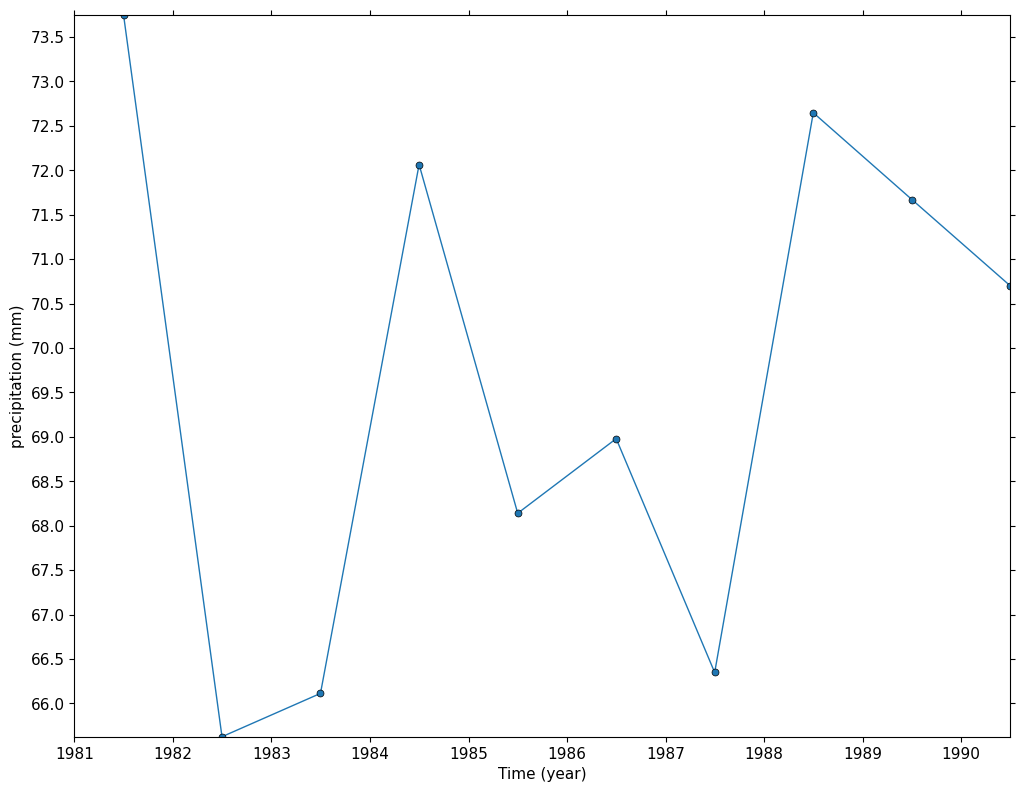

In [12]:
inverse_linear_regridded_field = monthly_field.regridc(yearly_field, method="linear", axes="T")
print(inverse_linear_regridded_field)
cfp.lineplot(inverse_linear_regridded_field, marker="o")

**6.c.5)** Regrid the reverse way to before, like in (6.c.4), but this time use the `"nearest_stod"` method of `regridc` which stands for 'nearest neighbour source to destination' interpolation. This will do the same regridding but using a different approach to the underlying calculation based upon mapping each destination point to the closest source point.

Call this `inverse_nearest_stod_regridded_field`. Inspect it with medium detail level and make a line plot of it showing markers.

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


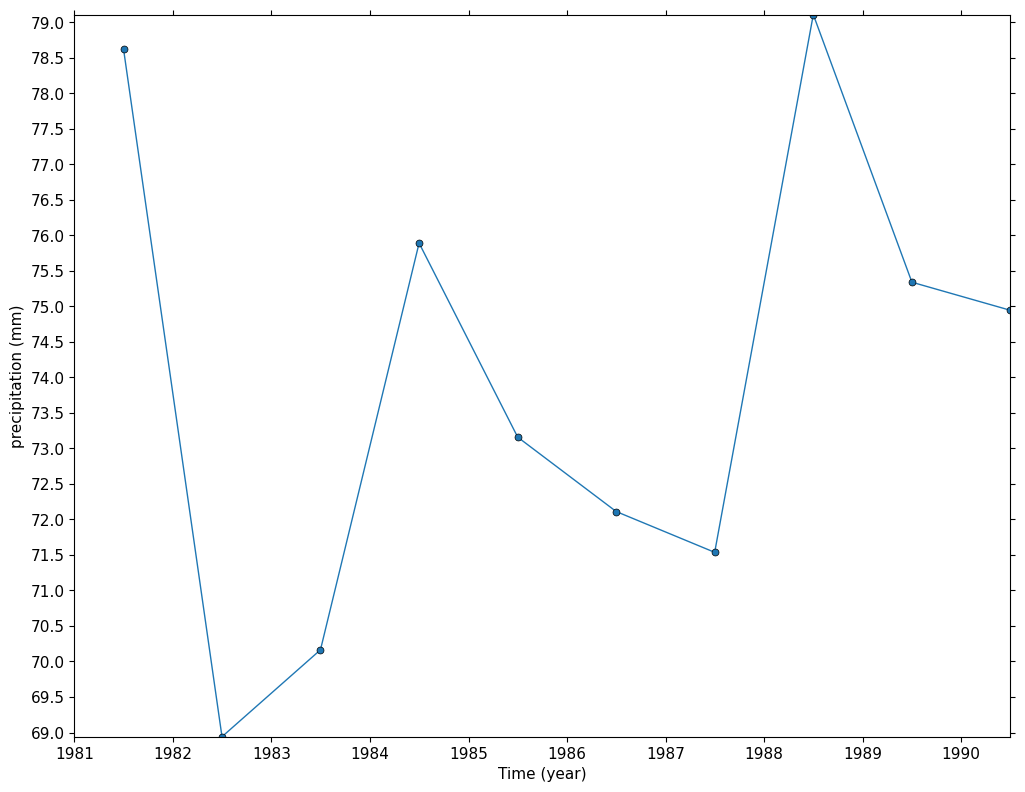

In [13]:
inverse_nearest_stod_regridded_field = monthly_field.regridc(yearly_field, method="nearest_stod", axes="T")
print(inverse_nearest_stod_regridded_field)
cfp.lineplot(inverse_nearest_stod_regridded_field, marker="o")

### d) Finally, some more advanced cf-plot plotting to compare the source, destination, and regridded results

**6.d.1)** Use cf-plot to make a plot with *two separate line plots* on one canvas (in either separate rows or columns, your choice), one of the first original field `yearly_field` and the linearly-regridded version of it, `linear_regridded_field`, so we can compare the original (un-regridded) and regridded result.

Use the code block from the teaching Notebook section (6b) as a guide, or otherwise: you will need to wrap all of the calls to `lineplot` within `cfp.gopen()` and `cfp.gclose()` so they are plotted on the same canvas and call `cfp.gpos(N)` with an integer starting at `N=1` to tell cf-plot to move on to the next position in the plot before making a `lineplot` call.

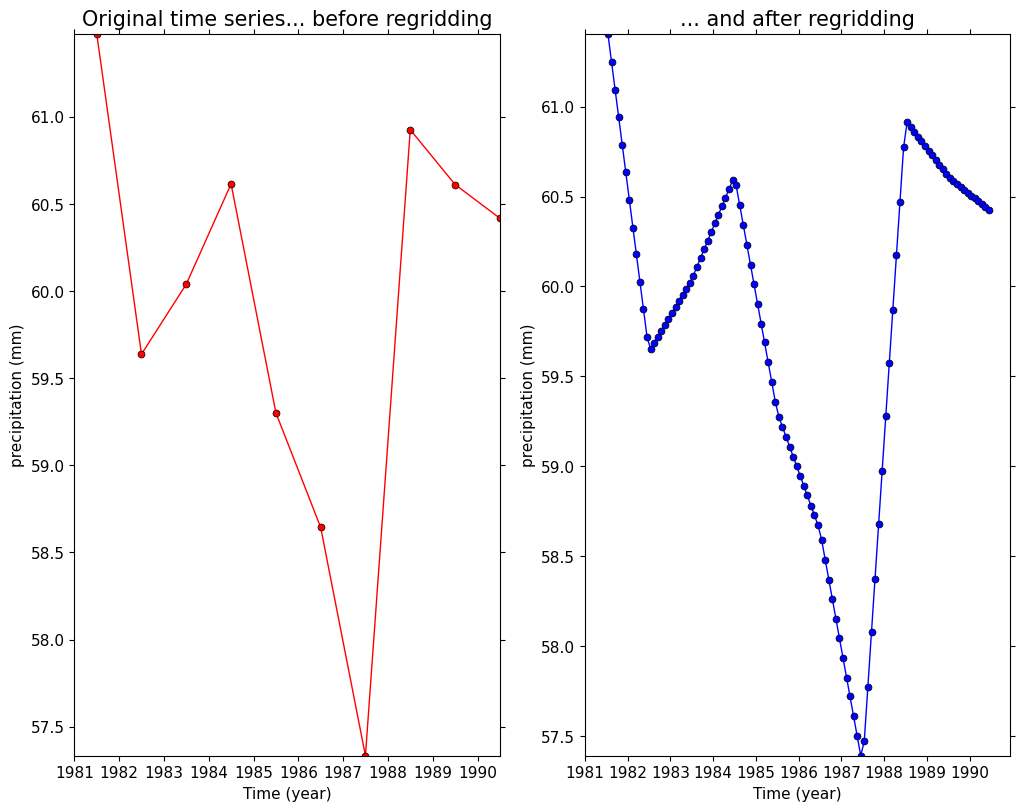

In [14]:
cfp.gopen(rows=1, columns=2)  # or could use rows=2, columns=1 for one column instead
cfp.gpos(1)
cfp.lineplot(
    yearly_field, marker="o", color="red", title="Original time series... before regridding")
cfp.gpos(2)
cfp.lineplot(linear_regridded_field, marker="o", color="blue", title="... and after regridding")
cfp.gclose()

**6.d.2)** This time, use cf-plot to make a plot with *multiple line plots plotted together on the same (x- and y-) axes*. Plot both original fields along with the two regridded `inverse_*_regridded_field`, this time, and plot them in different colours of your choosing with sensible descriptive labels:
1. `monthly_field`
2. `yearly_field`
3. `inverse_linear_regridded_field`
4. `inverse_nearest_stod_regridded_field`

Use the code block from the teaching Notebook section (5d) as a guide, or otherwise: you will need to wrap all of the calls to `lineplot` within `cfp.gopen()` and `cfp.gclose()` and by, not calling `cfp.gpos()` with position integers in the last question, all of the lines will be plotted onto the same canvas to share axes.

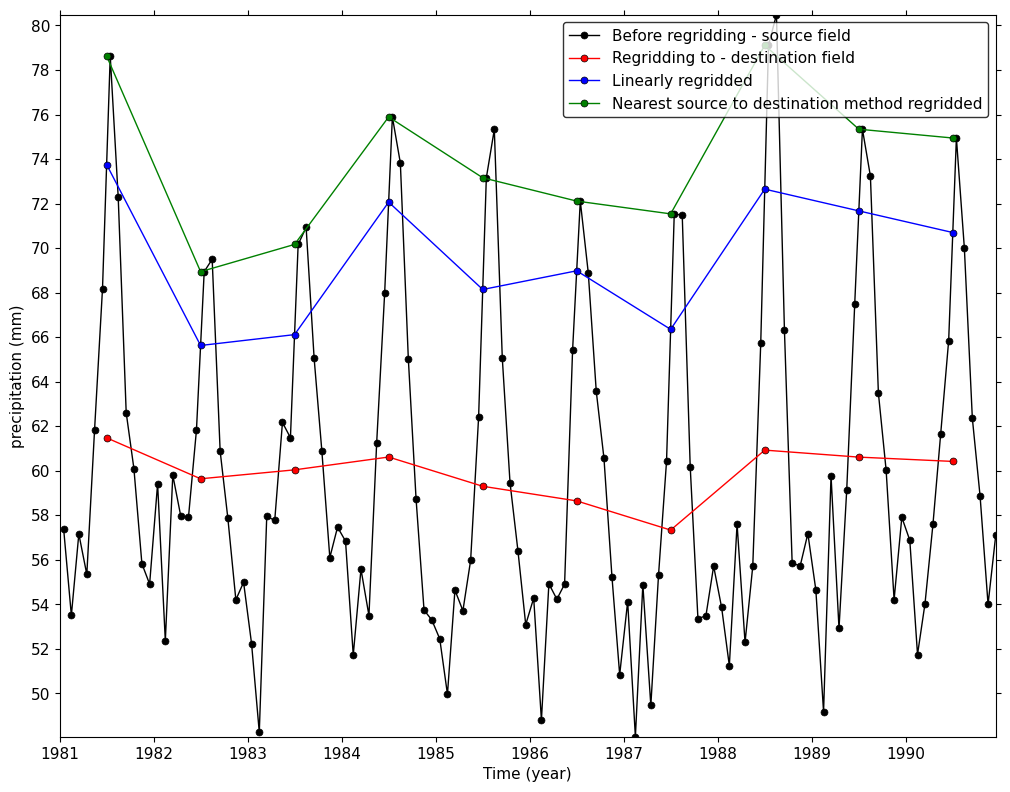

In [15]:
cfp.gopen()
cfp.lineplot(monthly_field, marker="o", color="black", label="Before regridding - source field")
cfp.lineplot(yearly_field, marker="o", color="red", label="Regridding to - destination field")
cfp.lineplot(inverse_linear_regridded_field, marker="o", color="blue", label="Linearly regridded")
cfp.lineplot(
    inverse_nearest_stod_regridded_field, marker="o", color="green", label="Nearest source to destination method regridded")
cfp.gclose()

**6.d.3)** Finally, study the two compound plots created in this section, in particular paying attention to the marker spacings representing the time data point sampling i.e. resolution which forms our grid in this context, to help you to ensure you understand the process of regridding.

Also, look back to the horizontal spatial regridding example plot in (6d) of the teaching Notebook and pay particular attention to the cell block sizes from before and after regridding, to remind yourself the output from a spatial regridding operation.

We've practiced regridding of fields in two contexts: spherical regridding in a 2D spatial context and Cartesian regridding in a 1D time series context. Hopefully these two examples have allowed you to understand what regridding does, but at least how cf-python can enable you to do it.

<div class="alert alert-block alert-success">
<i>Practical instructions:</i> this is the end of the section and the whole training course. Please check your work and review the material.
</div>

***